In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchsummary import summary

import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline
random.seed(123)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


In [3]:
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                    
    transform = ToTensor(), 
    download = True,            
)

In [4]:
dataloader = DataLoader(train_data, 50000, shuffle=False, num_workers=2)
X, _ = next(iter(dataloader))
mean, std = torch.mean(X).item(), torch.std(X).item()

In [5]:
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,                    
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True,
)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True
)

In [6]:
train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

## Architecture

In [7]:
class Baseline(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [8]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    """
    Runs one epoch for training or validation.
    """
    epoch_loss = 0
    correct = 0
    total_samples = len(dataloader.dataset)

    if train:
        model.train()
    else:
        model.eval()

    for X, y in tqdm(dataloader, desc=f'{"Train" if train else "Val"} Epoch'):
        X, y = X.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = model(X)
            loss = criterion(output, y)

        epoch_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        correct += torch.sum(y_pred == y).item()

        if train:
            loss.backward()
            optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct / total_samples

    return avg_loss, accuracy

def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience=None, delta=None):
    """
    Trains and evaluates the model for n_epochs.
    """
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('----------')

        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer, criterion, train=False)
            
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\nVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        if patience == None and delta == None:
            continue
        else:
            if val_loss < best_val_loss - delta:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                print(f'Val loss has not increased for {counter}/{patience} epochs')
                if counter >= patience:
                    print(f'Training stopped after {epoch+1} epochs')
                    break
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

## Init

In [ ]:
results = {}
n_epochs = 10

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)


## Baseline with ReLU

In [ ]:
model = Baseline(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 76.96it/s]


Train Loss: 1.4668, Train Accuracy: 0.4670
Val Loss: 1.2282, Val Accuracy: 0.5681

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 88.77it/s]


Train Loss: 1.0861, Train Accuracy: 0.6127
Val Loss: 1.0288, Val Accuracy: 0.6346

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 93.47it/s]


Train Loss: 0.9031, Train Accuracy: 0.6833
Val Loss: 0.9326, Val Accuracy: 0.6717

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 91.96it/s]


Train Loss: 0.7728, Train Accuracy: 0.7272
Val Loss: 0.8981, Val Accuracy: 0.6887

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 91.54it/s]


Train Loss: 0.6509, Train Accuracy: 0.7706
Val Loss: 0.8551, Val Accuracy: 0.7056

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 94.71it/s]


Train Loss: 0.5390, Train Accuracy: 0.8115
Val Loss: 0.8989, Val Accuracy: 0.7028

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 91.99it/s]


Train Loss: 0.4314, Train Accuracy: 0.8480
Val Loss: 0.9124, Val Accuracy: 0.7096

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.10it/s]


Train Loss: 0.3271, Train Accuracy: 0.8853
Val Loss: 0.9587, Val Accuracy: 0.7111

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 90.60it/s]


Train Loss: 0.2286, Train Accuracy: 0.9213
Val Loss: 1.1082, Val Accuracy: 0.7084

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 89.35it/s]

Train Loss: 0.1619, Train Accuracy: 0.9446
Val Loss: 1.2788, Val Accuracy: 0.7100


## Baseline with Tanh

In [ ]:
model = Baseline(activation=nn.Tanh()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline_tanh'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 93.30it/s]


Train Loss: 1.3733, Train Accuracy: 0.5097
Val Loss: 1.0896, Val Accuracy: 0.6163

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 91.97it/s]


Train Loss: 1.0039, Train Accuracy: 0.6474
Val Loss: 0.9708, Val Accuracy: 0.6590

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.83it/s]


Train Loss: 0.8509, Train Accuracy: 0.7007
Val Loss: 0.9065, Val Accuracy: 0.6913

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.47it/s]


Train Loss: 0.7206, Train Accuracy: 0.7488
Val Loss: 0.9044, Val Accuracy: 0.6832

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 91.88it/s]


Train Loss: 0.5829, Train Accuracy: 0.7978
Val Loss: 0.8798, Val Accuracy: 0.7000

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.27it/s]


Train Loss: 0.4344, Train Accuracy: 0.8533
Val Loss: 0.9283, Val Accuracy: 0.6982

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.70it/s]


Train Loss: 0.2949, Train Accuracy: 0.9042
Val Loss: 1.0010, Val Accuracy: 0.6955

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 94.22it/s]


Train Loss: 0.1742, Train Accuracy: 0.9478
Val Loss: 1.1147, Val Accuracy: 0.6908

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 89.71it/s]


Train Loss: 0.0972, Train Accuracy: 0.9744
Val Loss: 1.2479, Val Accuracy: 0.6915

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.69it/s]

Train Loss: 0.0709, Train Accuracy: 0.9806
Val Loss: 1.3302, Val Accuracy: 0.6889


## BatchNorm

In [13]:
class BatchNorm(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.activation(self.bn3(self.fc1(x)))
        x = self.activation(self.bn4(self.fc2(x)))
        return self.fc3(x)

In [14]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}

for name, function in activations.items():
    model = BatchNorm(activation=function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[f'batchnorm_{name}'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.88it/s]


Train Loss: 1.1776, Train Accuracy: 0.5815
Val Loss: 0.9865, Val Accuracy: 0.6482

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.26it/s]


Train Loss: 0.8089, Train Accuracy: 0.7147
Val Loss: 0.8482, Val Accuracy: 0.7016

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 72.34it/s]


Train Loss: 0.6226, Train Accuracy: 0.7815
Val Loss: 0.8838, Val Accuracy: 0.6909

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.48it/s]


Train Loss: 0.4646, Train Accuracy: 0.8387
Val Loss: 0.9465, Val Accuracy: 0.6905

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.77it/s]


Train Loss: 0.3191, Train Accuracy: 0.8904
Val Loss: 0.9285, Val Accuracy: 0.7134

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.77it/s]


Train Loss: 0.2218, Train Accuracy: 0.9258
Val Loss: 1.0063, Val Accuracy: 0.7100

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.37it/s]


Train Loss: 0.1498, Train Accuracy: 0.9505
Val Loss: 1.1199, Val Accuracy: 0.7109

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.44it/s]


Train Loss: 0.1073, Train Accuracy: 0.9651
Val Loss: 1.1996, Val Accuracy: 0.7036

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.20it/s]


Train Loss: 0.0873, Train Accuracy: 0.9714
Val Loss: 1.2026, Val Accuracy: 0.7138

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 69.25it/s]


Train Loss: 0.0806, Train Accuracy: 0.9727
Val Loss: 1.2784, Val Accuracy: 0.7115

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.67it/s]


Train Loss: 1.3577, Train Accuracy: 0.5188
Val Loss: 1.1773, Val Accuracy: 0.5867

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


Train Loss: 1.0317, Train Accuracy: 0.6388
Val Loss: 1.0299, Val Accuracy: 0.6425

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 69.84it/s]


Train Loss: 0.8816, Train Accuracy: 0.6928
Val Loss: 0.9918, Val Accuracy: 0.6548

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.93it/s]


Train Loss: 0.7747, Train Accuracy: 0.7287
Val Loss: 0.9195, Val Accuracy: 0.6857

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.97it/s]


Train Loss: 0.6839, Train Accuracy: 0.7607
Val Loss: 0.9434, Val Accuracy: 0.6787

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 71.59it/s]


Train Loss: 0.5810, Train Accuracy: 0.7971
Val Loss: 0.9540, Val Accuracy: 0.6840

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.39it/s]


Train Loss: 0.4882, Train Accuracy: 0.8313
Val Loss: 1.0003, Val Accuracy: 0.6784

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 76.97it/s]


Train Loss: 0.3923, Train Accuracy: 0.8667
Val Loss: 1.0040, Val Accuracy: 0.6942

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.42it/s]


Train Loss: 0.3055, Train Accuracy: 0.8961
Val Loss: 1.1308, Val Accuracy: 0.6818

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.08it/s]

Train Loss: 0.2197, Train Accuracy: 0.9263
Val Loss: 1.3104, Val Accuracy: 0.6685


## Dropout without BatchNorm

In [16]:
class Dropout(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        return self.fc3(x)

In [17]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}

for name, function in activations.items():
    model = Dropout(activation=function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[f'dropout_{name}'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 93.21it/s]


Train Loss: 1.6488, Train Accuracy: 0.3953
Val Loss: 1.2745, Val Accuracy: 0.5362

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.85it/s]


Train Loss: 1.2841, Train Accuracy: 0.5390
Val Loss: 1.1056, Val Accuracy: 0.6049

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 94.51it/s]


Train Loss: 1.1203, Train Accuracy: 0.6035
Val Loss: 1.0339, Val Accuracy: 0.6344

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 94.80it/s]


Train Loss: 1.0134, Train Accuracy: 0.6467
Val Loss: 0.9257, Val Accuracy: 0.6744

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 88.31it/s]


Train Loss: 0.9334, Train Accuracy: 0.6753
Val Loss: 0.9091, Val Accuracy: 0.6799

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 91.94it/s]


Train Loss: 0.8653, Train Accuracy: 0.7014
Val Loss: 0.8630, Val Accuracy: 0.6984

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 89.49it/s]


Train Loss: 0.7967, Train Accuracy: 0.7262
Val Loss: 0.8524, Val Accuracy: 0.7018

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.46it/s]


Train Loss: 0.7412, Train Accuracy: 0.7415
Val Loss: 0.8438, Val Accuracy: 0.7071

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 89.04it/s]


Train Loss: 0.6888, Train Accuracy: 0.7604
Val Loss: 0.8306, Val Accuracy: 0.7104

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.27it/s]


Train Loss: 0.6396, Train Accuracy: 0.7785
Val Loss: 0.8238, Val Accuracy: 0.7209

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 93.35it/s]


Train Loss: 1.5072, Train Accuracy: 0.4576
Val Loss: 1.1832, Val Accuracy: 0.5787

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.79it/s]


Train Loss: 1.1888, Train Accuracy: 0.5850
Val Loss: 1.0657, Val Accuracy: 0.6295

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 93.32it/s]


Train Loss: 1.0779, Train Accuracy: 0.6275
Val Loss: 1.0081, Val Accuracy: 0.6487

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.36it/s]


Train Loss: 0.9983, Train Accuracy: 0.6573
Val Loss: 0.9500, Val Accuracy: 0.6717

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.62it/s]


Train Loss: 0.9455, Train Accuracy: 0.6718
Val Loss: 0.9191, Val Accuracy: 0.6846

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.66it/s]


Train Loss: 0.8937, Train Accuracy: 0.6917
Val Loss: 0.9635, Val Accuracy: 0.6732

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 92.82it/s]


Train Loss: 0.8584, Train Accuracy: 0.7031
Val Loss: 0.9505, Val Accuracy: 0.6764

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 93.24it/s]


Train Loss: 0.8073, Train Accuracy: 0.7184
Val Loss: 0.9056, Val Accuracy: 0.6902

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 73.35it/s]


Train Loss: 0.7733, Train Accuracy: 0.7344
Val Loss: 0.8799, Val Accuracy: 0.6977

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 88.28it/s]

Train Loss: 0.7345, Train Accuracy: 0.7468
Val Loss: 0.8764, Val Accuracy: 0.7046


## Dropout with BatchNorm

In [18]:
class DropoutBatchNorm(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout(self.activation(self.bn3(self.fc1(x))))
        x = self.dropout(self.activation(self.bn4(self.fc2(x))))
        return self.fc3(x)

In [ ]:
model = DropoutBatchNorm(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results[f'dropout_batchnorm_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.60it/s]


Train Loss: 1.3933, Train Accuracy: 0.5023
Val Loss: 1.0436, Val Accuracy: 0.6321

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.91it/s]


Train Loss: 1.0512, Train Accuracy: 0.6340
Val Loss: 0.9492, Val Accuracy: 0.6683

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.96it/s]


Train Loss: 0.9198, Train Accuracy: 0.6813
Val Loss: 0.8760, Val Accuracy: 0.6924

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.61it/s]


Train Loss: 0.8335, Train Accuracy: 0.7115
Val Loss: 0.8869, Val Accuracy: 0.6817

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.03it/s]


Train Loss: 0.7732, Train Accuracy: 0.7323
Val Loss: 0.7941, Val Accuracy: 0.7225

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.33it/s]


Train Loss: 0.7095, Train Accuracy: 0.7531
Val Loss: 0.7560, Val Accuracy: 0.7385

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.56it/s]


Train Loss: 0.6502, Train Accuracy: 0.7743
Val Loss: 0.7755, Val Accuracy: 0.7341

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.41it/s]


Train Loss: 0.6011, Train Accuracy: 0.7941
Val Loss: 0.7673, Val Accuracy: 0.7355

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.02it/s]


Train Loss: 0.5557, Train Accuracy: 0.8063
Val Loss: 0.7843, Val Accuracy: 0.7331

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.21it/s]


Train Loss: 0.5127, Train Accuracy: 0.8199
Val Loss: 0.7727, Val Accuracy: 0.7437

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.44it/s]


Train Loss: 1.4893, Train Accuracy: 0.4708
Val Loss: 1.2034, Val Accuracy: 0.5694

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.18it/s]


Train Loss: 1.1704, Train Accuracy: 0.5896
Val Loss: 1.0603, Val Accuracy: 0.6262

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.85it/s]


Train Loss: 1.0397, Train Accuracy: 0.6362
Val Loss: 1.0064, Val Accuracy: 0.6422

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.17it/s]


Train Loss: 0.9703, Train Accuracy: 0.6608
Val Loss: 0.9460, Val Accuracy: 0.6700

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 75.18it/s]


Train Loss: 0.9068, Train Accuracy: 0.6846
Val Loss: 0.9173, Val Accuracy: 0.6797

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 76.26it/s]


Train Loss: 0.8614, Train Accuracy: 0.7013
Val Loss: 0.9372, Val Accuracy: 0.6688

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 76.03it/s]


Train Loss: 0.8266, Train Accuracy: 0.7149
Val Loss: 0.9607, Val Accuracy: 0.6663

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.53it/s]


Train Loss: 0.7896, Train Accuracy: 0.7244
Val Loss: 0.9233, Val Accuracy: 0.6784

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.83it/s]


Train Loss: 0.7526, Train Accuracy: 0.7375
Val Loss: 0.9213, Val Accuracy: 0.6855

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.77it/s]

Train Loss: 0.7284, Train Accuracy: 0.7488
Val Loss: 0.9176, Val Accuracy: 0.6808


## More Epochs

In [ ]:
n_epochs = 15

model = DropoutBatchNorm(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)


Epoch 1/30
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 70.17it/s]


Train Loss: 1.4478, Train Accuracy: 0.4807
Val Loss: 1.1020, Val Accuracy: 0.6127

Epoch 2/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.08it/s]


Train Loss: 1.1056, Train Accuracy: 0.6110
Val Loss: 0.9095, Val Accuracy: 0.6829

Epoch 3/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 90.16it/s]


Train Loss: 0.9625, Train Accuracy: 0.6645
Val Loss: 0.8645, Val Accuracy: 0.7025

Epoch 4/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 89.24it/s]


Train Loss: 0.8712, Train Accuracy: 0.6984
Val Loss: 0.8211, Val Accuracy: 0.7128

Epoch 5/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.90it/s]


Train Loss: 0.7964, Train Accuracy: 0.7248
Val Loss: 0.7726, Val Accuracy: 0.7279

Epoch 6/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.78it/s]


Train Loss: 0.7491, Train Accuracy: 0.7421
Val Loss: 0.7685, Val Accuracy: 0.7343

Epoch 7/30
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 72.25it/s]


Train Loss: 0.6897, Train Accuracy: 0.7619
Val Loss: 0.7643, Val Accuracy: 0.7395

Epoch 8/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.63it/s]


Train Loss: 0.6594, Train Accuracy: 0.7719
Val Loss: 0.7250, Val Accuracy: 0.7486

Epoch 9/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.50it/s]


Train Loss: 0.5970, Train Accuracy: 0.7912
Val Loss: 0.7324, Val Accuracy: 0.7474

Epoch 10/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.65it/s]


Train Loss: 0.5683, Train Accuracy: 0.8039
Val Loss: 0.7342, Val Accuracy: 0.7489

Epoch 11/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.77it/s]


Train Loss: 0.5414, Train Accuracy: 0.8137
Val Loss: 0.7301, Val Accuracy: 0.7512

Epoch 12/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.22it/s]


Train Loss: 0.5098, Train Accuracy: 0.8225
Val Loss: 0.7427, Val Accuracy: 0.7503

Epoch 13/30
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 74.78it/s]


Train Loss: 0.4641, Train Accuracy: 0.8386
Val Loss: 0.7464, Val Accuracy: 0.7517

Epoch 14/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.42it/s]


Train Loss: 0.4360, Train Accuracy: 0.8493
Val Loss: 0.7672, Val Accuracy: 0.7519

Epoch 15/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 81.74it/s]


Train Loss: 0.4408, Train Accuracy: 0.8485
Val Loss: 0.7744, Val Accuracy: 0.7541

Epoch 16/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.37it/s]


Train Loss: 0.3959, Train Accuracy: 0.8623
Val Loss: 0.7717, Val Accuracy: 0.7528

Epoch 17/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.37it/s]


Train Loss: 0.3671, Train Accuracy: 0.8716
Val Loss: 0.7794, Val Accuracy: 0.7588

Epoch 18/30
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.42it/s]


Train Loss: 0.4451, Train Accuracy: 0.8501
Val Loss: 0.7718, Val Accuracy: 0.7450

Epoch 19/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.81it/s]


Train Loss: 0.3759, Train Accuracy: 0.8700
Val Loss: 0.8528, Val Accuracy: 0.7328

Epoch 20/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.13it/s]


Train Loss: 0.3334, Train Accuracy: 0.8857
Val Loss: 0.7989, Val Accuracy: 0.7533

Epoch 21/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.83it/s]


Train Loss: 0.3950, Train Accuracy: 0.8660
Val Loss: 0.7812, Val Accuracy: 0.7524

Epoch 22/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.00it/s]


Train Loss: 0.3147, Train Accuracy: 0.8912
Val Loss: 0.8016, Val Accuracy: 0.7549

Epoch 23/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.25it/s]


Train Loss: 0.3131, Train Accuracy: 0.8928
Val Loss: 0.8167, Val Accuracy: 0.7555

Epoch 24/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 89.42it/s]


Train Loss: 0.3327, Train Accuracy: 0.8869
Val Loss: 0.8208, Val Accuracy: 0.7507

Epoch 25/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.40it/s]


Train Loss: 0.3577, Train Accuracy: 0.8791
Val Loss: 0.8099, Val Accuracy: 0.7458

Epoch 26/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.36it/s]


Train Loss: 0.2839, Train Accuracy: 0.9022
Val Loss: 0.8436, Val Accuracy: 0.7449

Epoch 27/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.78it/s]


Train Loss: 0.2921, Train Accuracy: 0.9006
Val Loss: 0.9019, Val Accuracy: 0.7327

Epoch 28/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.62it/s]


Train Loss: 0.2602, Train Accuracy: 0.9102
Val Loss: 0.8264, Val Accuracy: 0.7543

Epoch 29/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.08it/s]


Train Loss: 0.2526, Train Accuracy: 0.9137
Val Loss: 0.8508, Val Accuracy: 0.7504

Epoch 30/30
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.95it/s]

Train Loss: 0.2450, Train Accuracy: 0.9167
Val Loss: 0.8650, Val Accuracy: 0.7499


How far can you bring up the test accuracy by continuing the training
possibly over more epochs?

## figs and nuts version

In [22]:
class FigNuts(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.bn1(self.activation(self.conv1(x))))
        x = self.pool(self.bn2(self.activation(self.conv2(x))))
        x = self.flatten(x)
        x = self.bn3(self.dropout(self.activation(self.fc1(x))))
        x = self.bn4(self.dropout(self.activation(self.fc2(x))))
        return self.fc3(x)

In [23]:
model = FigNuts(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results[f'fig_and_nuts_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.72it/s]


Train Loss: 1.4614, Train Accuracy: 0.4760
Val Loss: 1.1112, Val Accuracy: 0.6025

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.18it/s]


Train Loss: 1.1096, Train Accuracy: 0.6089
Val Loss: 0.9412, Val Accuracy: 0.6676

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.38it/s]


Train Loss: 0.9675, Train Accuracy: 0.6642
Val Loss: 0.8702, Val Accuracy: 0.6886

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.12it/s]


Train Loss: 0.8682, Train Accuracy: 0.6989
Val Loss: 0.8296, Val Accuracy: 0.7126

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 83.56it/s]


Train Loss: 0.7895, Train Accuracy: 0.7270
Val Loss: 0.8159, Val Accuracy: 0.7154

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.45it/s]


Train Loss: 0.7418, Train Accuracy: 0.7429
Val Loss: 0.7763, Val Accuracy: 0.7252

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 86.03it/s]


Train Loss: 0.6887, Train Accuracy: 0.7624
Val Loss: 0.8356, Val Accuracy: 0.7115

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.35it/s]


Train Loss: 0.6467, Train Accuracy: 0.7783
Val Loss: 0.7964, Val Accuracy: 0.7248

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.11it/s]


Train Loss: 0.6583, Train Accuracy: 0.7742
Val Loss: 0.7739, Val Accuracy: 0.7355

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.10it/s]

Train Loss: 0.5814, Train Accuracy: 0.7993
Val Loss: 0.8651, Val Accuracy: 0.7065


## Comparison

In [31]:
def plot_loss_curves(n_epochs, results):
    
    fig, ax = plt.subplots(2, 2, figsize=(24,18))
    
    line_styles = ['-', '--', '-.', ':']
    colors = plt.cm.tab10.colors
    
    for i, (name, metric) in enumerate(results.items()):

        style = random.choice(line_styles)
        color = colors[i % len(colors)]

        x = range(1, n_epochs + 1)

        ax[0, 0].plot(x, metric[0], linestyle=style, color=color, label=name)
        ax[0, 0].set_title('Train Loss')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].set_ylim(0, 1.7)

        ax[0, 1].plot(x, metric[1], linestyle=style, color=color, label=name)
        ax[0, 1].set_title('Validation Loss')
        ax[0, 1].set_ylabel('Loss')
        ax[0, 1].set_ylim(0, 1.7)
        
        ax[1, 0].plot(x, metric[2], linestyle=style, color=color, label=name)
        ax[1, 0].set_title('Train Accuracy')
        ax[1, 0].set_ylabel('Accuracy')
        ax[1, 0].set_ylim(0.4, 1)

        ax[1, 1].plot(x, metric[3], linestyle=style, color=color, label=name)
        ax[1, 1].set_title('Validation Accuracy')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].set_ylim(0.4, 1)
        
    for axes in ax.flat:
        axes.set_xlabel('Epochs')
        axes.set_xticks(range(1, n_epochs+1))
        axes.grid()
        axes.legend()

    fig.suptitle('Train/Val Losses and Accuracies', fontsize=18)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (30,) and (10,)

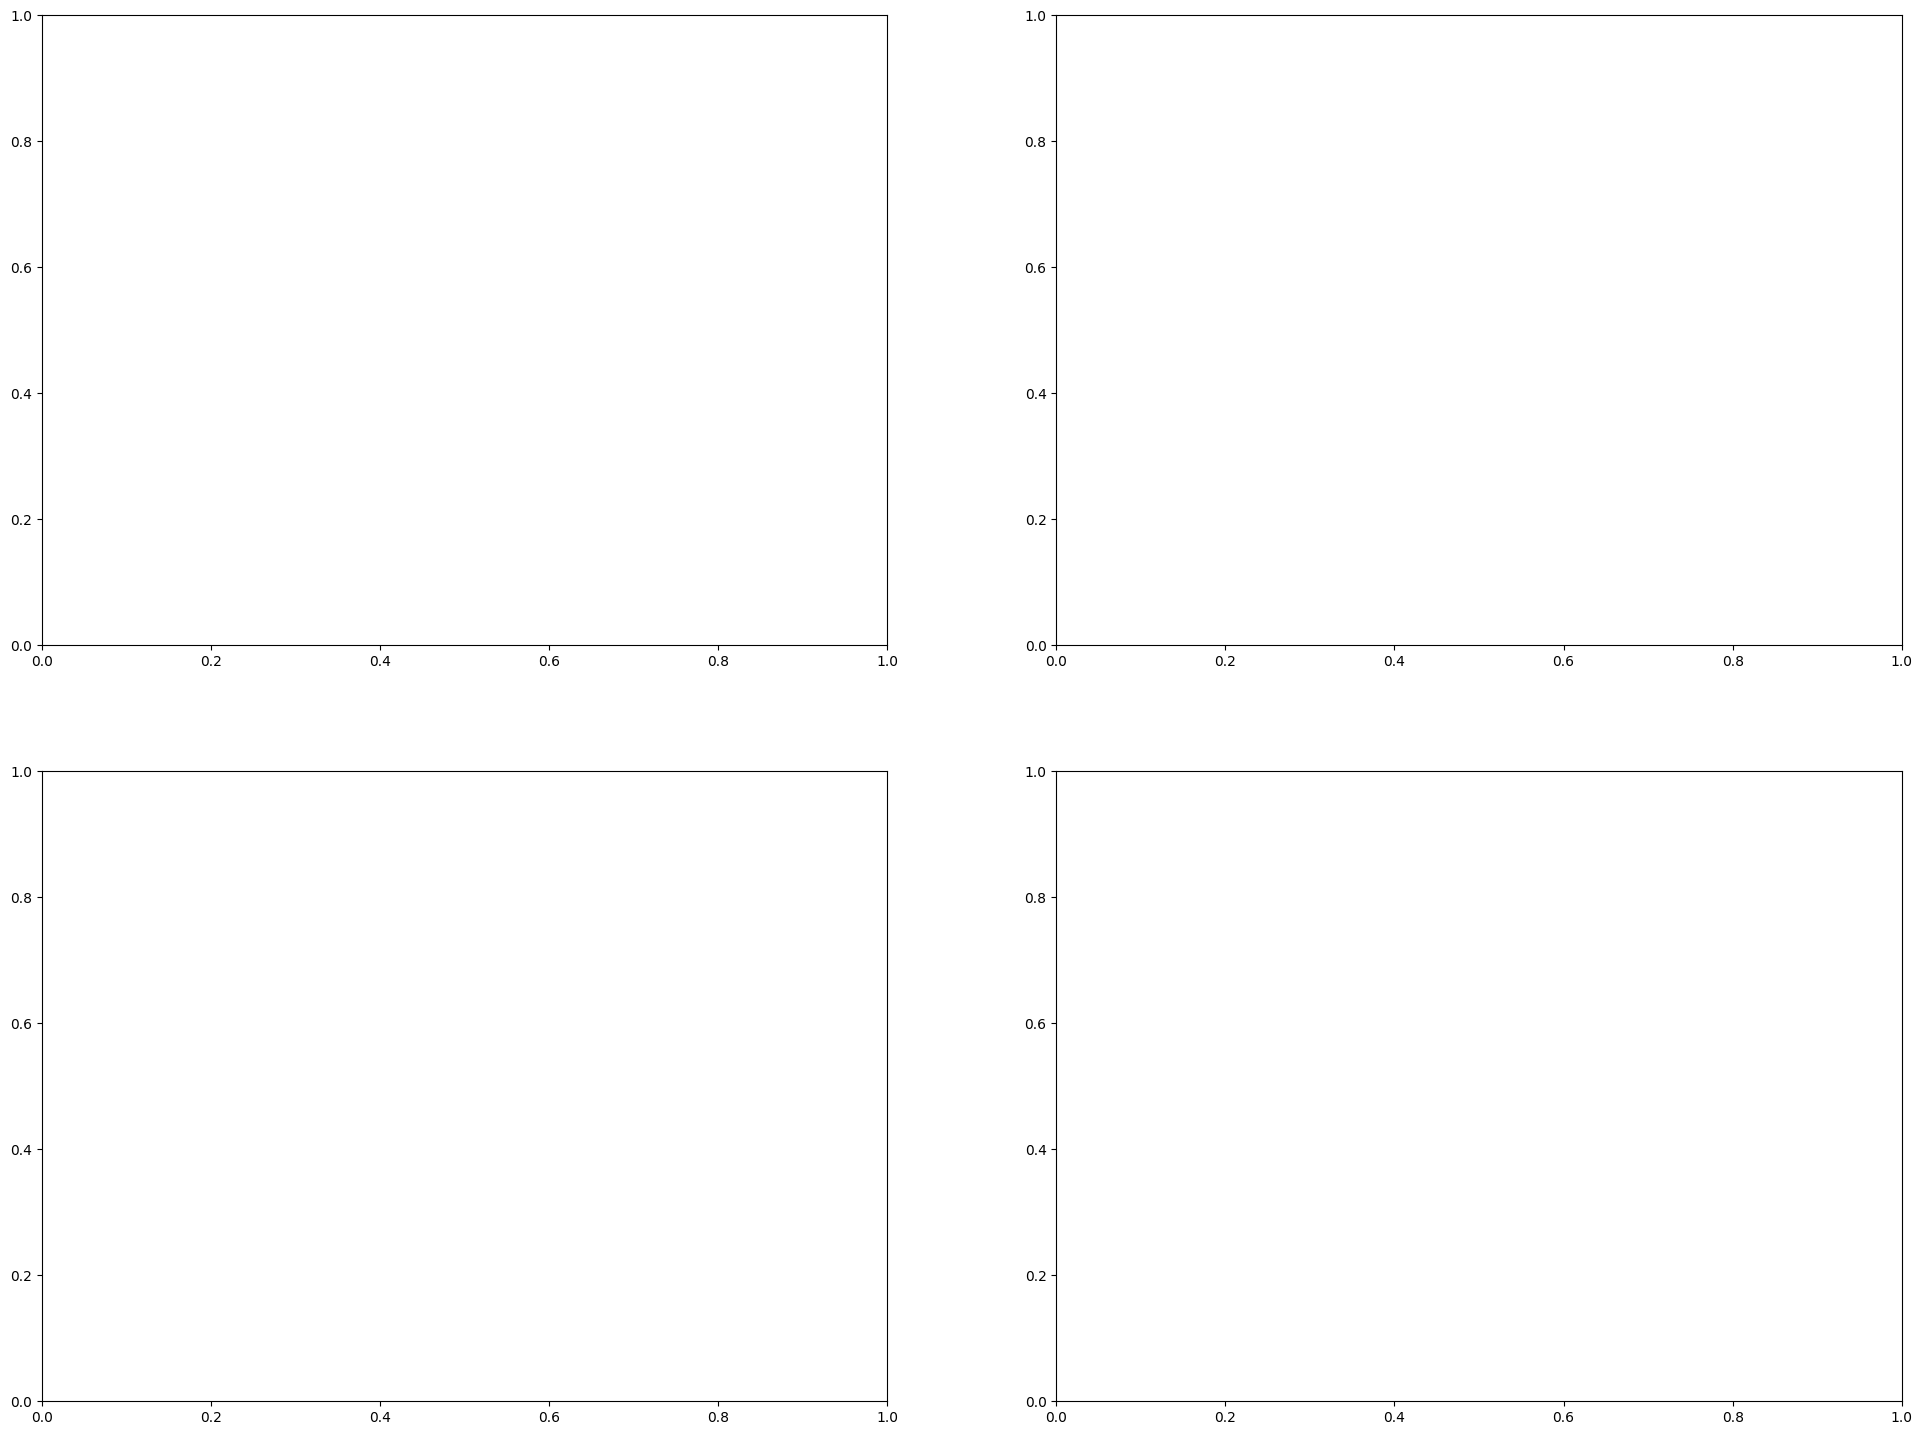

In [32]:
plot_loss_curves(n_epochs, results)

## Discussion

Discuss your findings and make a statement about whether the
results are as you expect.